<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/MNIST_Val_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-1xj3j6z4/base-rbt_4f72b8172ffb48f09a7977bae7a419a5
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-1xj3j6z4/base-rbt_4f72b8172ffb48f09a7977bae7a419a5
     |████████████████████████████████| 551 kB 4.0 MB/s 
     |████████████████████████████████| 41 kB 190 kB/s 
     |████████████████████████████████| 549 kB 82.9 MB/s 
     |████████████████████████████████| 182 kB 66.2 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=20558 sha256=2f2fb8aa018b7489c956da2a061bc846871aabfd01f49e53b8a40376f65d0167
  Stored in directory: /tmp/pip-ephem-wheel-cache-77yajxai/wheels/7c/4c/c6/65c6f336ed53f534c05ca6736718e1e18f359920a1ef911674
Successfully built base-rbt


In [2]:
from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

In [3]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

Step 1): We need the data, and to set all the hps. 

In [4]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=42 #Will have to try with different random seeds. Two times is probably enough 
n_in=1
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=28
ps=500 #Will also try with other values e.g. 125, 1000 etc
bs=128 #for training BT
bs_val=20 #for training linear head
bs_test=500
ts_val=bs_val*4 #so 512, ~ 1% of 50000
ts=10000

n_epochs=300 #epochs for BT 
numfit = 200 #epochs for linear classifer

In [5]:
#Let's get MNIST data in a nicer way

path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()
seed_everything(seed=seed)
items=items.shuffle()
label_func=RegexLabeller(pat = r'/training/(\d)/')
labels = [label_func(i) for i in items]

items_train = items[0:ts] #train on ts samples
labels_train = labels[0:ts]
dls_train = ImageDataLoaders.from_lists(path,items_train, labels_train,bs=bs,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,item_tfms=[ToTensor()],
                                  img_cls=PILImageBW)

items_tune = items[ts:ts+3000]
labels_tune = labels[ts:ts+3000]

items_test = items[ts+3000:ts+3000+ts] #test on ts samples. 3k held out for tuning
labels_test = labels[ts+3000:ts+3000+ts]
dls_test = ImageDataLoaders.from_lists(path,items_test, labels_test,bs=bs_test,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                  img_cls=PILImageBW)

def tune_set(items0,seed=42):

    seed_everything(seed=seed)
    items=items0.shuffle()
    raw=[]
    items_tune20 = []
    labels_tune20 = []

    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}

    for i in items:
    
        label = label_func(i)
        if d[label] == 0 or d[label] == 1:
            items_tune20.append(i)
            labels_tune20.append(label)
            d[label] += 1
            raw.append(i)

    dls_val = ImageDataLoaders.from_lists(path, items_tune20, labels_tune20,bs=20,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                      img_cls=PILImageBW)

    d = {'items_tune20':items_tune20,'labels_tune20':labels_tune20,'raw':raw,'dls_val':dls_val}
    
    return d


In [ ]:
#Test dls_train, dls_val, dls_test and that function `tune_set` is working 

test_eq(seed,42)
test_eq(ts,10000)

x,y = dls_train.one_batch()
test_eq(x.shape, [bs, 1, 28, 28])

test_eq(len(dls_train.train_ds),ts)
test_eq(len(dls_test.train_ds),ts)

test_eq(len(dls_test.train)*bs_test,len(dls_test.train_ds))

_tune_set = tune_set(items_tune,seed=seed+1)
items_tune20,labels_tune20,dls_val,raw = _tune_set['items_tune20'],_tune_set['labels_tune20'], _tune_set['dls_val'],_tune_set['raw']


my_dict = {i:labels_tune20.count(i) for i in labels_tune20}
for i in my_dict.values():
    test_eq(i,2)

#test size
test_eq(len(dls_val.train),1)
test_eq(len(dls_val.train_ds),20)

#test random seed (please note that this depends on random seed chosen above to sort initially, i.e. seed=42)
_raw = tune_set(items_tune,seed=1)['raw']
test_eq(_raw[0].name,'28316.png')

_raw = tune_set(items_tune,seed=10)['raw']
test_eq(_raw[11].name,'11658.png')


Test the random seed:

Patch in definition of loss function (BT for now):

In [ ]:
#Eventually have to edit elsewhere

def random_sinusoid(x,std=0.1,phase_std=0.1,amp_std=0.2,off_std=1):
    
    device=default_device().type
    ps = x.shape[1]

    X = torch.randn(6,ps).to(device) #use this to get t,s,u,v,a,b i.e. random components of sinusoid
    
    t,s = phase_std*X[0:2,:]
    u,v = off_std=X[2:4,:]
    a,b = amp_std*X[4:6,:]

   
    return a*torch.sin(t*x[:,]*math.pi+u) + b*torch.cos(s*x[:,]*math.pi+v)


#| export
class Cdiff_Rand:
    
    def __init__(self,
                 phase_std=0.2,amp_std=0.2,off_std=1,
                 K=2,indep=False):
        store_attr()
        

    def __call__(self,z1norm,z2norm):
        
        K=self.K
        cdiff_rand=0
        for i in range(K):
            
            z1norm_2 = random_sinusoid(x=z1norm,phase_std=self.phase_std,amp_std=self.amp_std,off_std=self.off_std)
            z2norm_2 = random_sinusoid(x=z2norm,phase_std=self.phase_std,amp_std=self.amp_std,off_std=self.off_std)

            cdiff_rand = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)

        cdiff_rand=(1/K)*cdiff_rand
    
        return cdiff_rand

def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,indep=True):

    bs = z1norm.shape[0]
    if indep == False:
        C1 =  (z1norm.T @ z2norm_2) / bs
        C2 = (z1norm_2.T @ z2norm) / bs
        cdiff = (0.5*C1.pow(2) + 0.5*C2.pow(2))
        
    elif indep == True:
        cdiff =  (z1norm_2.T @ z2norm_2) / bs
    
    return cdiff

class Max_Corr(nn.Module):
    def __init__(self,qs,act1='relu',act2='sigmoid'):
        super().__init__()
        self.qs=qs
        # self.mask = torch.ones(qs,qs) * (torch.ones(qs,qs)-torch.eye(qs))
        # if default_device().type == 'cuda': self.mask=self.mask.cuda()

        # t1 = torch.ones(qs,1)
        # t2 = torch.zeros(qs,qs-1)
        # self.mask2 = torch.cat((t1,t2),1)
        # if default_device().type == 'cuda': self.mask2=self.mask2.cuda()

        
        self.fc1 = nn.Linear(qs,qs)
        #self.fc1.weight.register_hook(lambda grad: grad*self.mask)
        self.fc11 = nn.Linear(qs,qs)
        #self.fc11.weight.register_hook(lambda grad: grad*self.mask)
        self.fc2 = nn.Linear(qs,qs)
        #self.fc2.weight.register_hook(lambda grad: grad*self.mask)
        self.fc22 = nn.Linear(qs,qs)
        #self.fc22.weight.register_hook(lambda grad: grad*self.mask)

        if act1=='relu': self.act1=nn.ReLU() 
        elif act1 == 'sigmoid': self.act1 = nn.Sigmoid()

        if act2=='relu': self.act2=nn.ReLU() 
        elif act2 == 'sigmoid': self.act2 = nn.Sigmoid()
        
        self.m1 = nn.Sequential(self.fc1,self.act1,self.fc11)
        #self.m2 = nn.Sequential(self.fc2,nn.ReLU(),nn.Linear(qs,qs,bias=False)) #feedforward net one hidden layer
        self.m2 = nn.Sequential(self.fc1,self.act2,self.fc11)

    def forward(self,x,y):
        return self.m1(x),self.m2(y)
        
#| export
class Cdiff_Sup:
    
    def __init__(self,I,qs,inner_steps,indep=True,act1='relu',act2='sigmoid',mask=True):
        
        self.I=I
        self.qs=qs
        self.inner_steps=inner_steps
        self.indep=indep

        self.act1=act1
        self.act2=act2

        self.max_corr = Max_Corr(qs=qs,act1=self.act1,act2=self.act2)
        if default_device().type == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        inner_steps=self.inner_steps
        z1norm=z1norm.detach()
        z2norm=z2norm.detach()
        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        
        for i in range(inner_steps):

            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)
            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)
            inner_loss=-1*(cdiff_2*(1-self.I)).mean()
            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)


            
            return cdiff_sup

In [ ]:
#Using BT
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred, self.I,self.lmb)

In [ ]:
def lf_rbt(pred,seed,I,lmb):
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=10,indep=False,mask=True)
    cdiff_2 = CdiffSup(z1norm,z2norm) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=20,indep=True) #Best so far
    cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

    cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2 #convex combination of rand and sup terms.

    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

In [ ]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


HP = AttributeDict(t=0.5, #convexity level
               indep_rand=True,indep_sup=False,enc_rand=False,enc_sup=True, 
               inner_steps=15,act1='relu',act2='sigmoid', #belong to sup term
               K=10,phase_std=0.2,amp_std=0.2,off_std=1)


def lf_rbt_enc(pred,I,lmb,
               hp,
               ):

    pred_enc = pred[0]
    pred = pred[1]
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    
    z1_enc, z2_enc = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / z1_enc.std(0, unbiased=False)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / z2_enc.std(0, unbiased=False)

    if hp.enc_rand:
        z1norm_rand = z1norm_enc
        z2norm_rand = z2norm_enc

    else:
        z1norm_rand = z1norm
        z2norm_rand = z2norm

    if hp.enc_sup:
        z1norm_sup = z1norm_enc
        z2norm_sup = z2norm_enc

    else:
        z1norm_sup = z1norm
        z2norm_sup = z2norm


    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    # #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    # #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=hp.inner_steps,indep=hp.indep_sup)
    cdiff_2 = CdiffSup(z1norm_sup,z2norm_sup) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(phase_std=hp.phase_std,amp_std=hp.amp_std,off_std=hp.off_std,
                           K=hp.K,indep=hp.indep_rand
                           )
    cdiff_2_2 = CdiffRand(z1norm_rand,z2norm_rand) #same shape as cdiff

    #cdiff_2 = hp.t*cdiff_2_2 + (1-hp.t)*cdiff_2 #convex combination of rand and sup terms.
    
    cdiff_2 = hp.t*cdiff_2_2 + (1-hp.t)*cdiff_2 #i.e. rand term + bt term (no sup term)
    
    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

In [ ]:
# #Using RBT_enc
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt_enc(pred,I=self.I,lmb=self.lmb,hp=HP)

We also patch `before_epoch` so that we are training linear classifier:
    

Setup for linear evaluation:

In [ ]:
aug_pipelines_val=[get_linear_batch_augs(size=28,stats=mnist_stats,resize=True,resize_scale=(0.4, 1.0))]
main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                    dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                    stats=mnist_stats,
                    aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                    encoder=None#encoder
                                )

Optional: Show linear augmentations:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


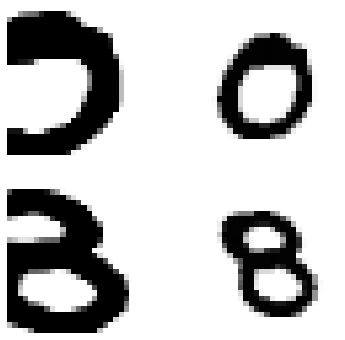

In [ ]:
show_linear_batch(dls=dls_val,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Patch linear evaluation into `after_epoch:`

Define encoder and model; Define augmentation pipelines; Define learner.  

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

#If we are using a different model, this call will just look like `create_rat_model(...)`
model = create_p3barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))


#aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)

# noise=True,rotate=True,jitter=True,bw=True,blur=True,solar=True, #Whether to use  given aug or not
# resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.025, rotate_deg=30,jitter_s=.6,blur_s=(4,32),s1=None,sol_t=0.05,sol_a=0.05, #hps of diff augs
# flip_p=0.5, rotate_p=0.3,noise_p=0.2, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1, #prob of performing aug
# same_on_batch=False,stats=imagenet_stats,cuda=default_device().type == 'cuda',xtra_tfms=[])

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#If we are using a different `callback` to `BarlowTwins` then we can simply replace `BarlowTwins` with 
#e.g. `BarlowTriplets`. We can define in base_model and just import with no issues. 
learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
#Set path of learn correctly
#learn.path = Path('/content/drive/MyDrive/')

Step 3): (Optional): View the augmentations:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 's1': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 's1': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}


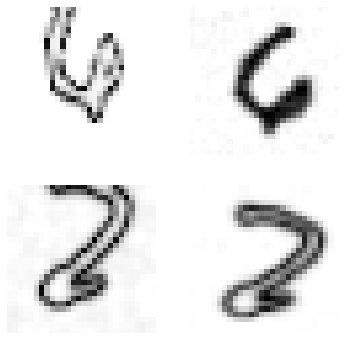

In [ ]:
show_bt_batch(dls=dls_train,n_in=n_in,aug=aug_pipelines,n=2,print_augs=True)

Step 4): Fit the learner:

All we have changed from "best so far" on current run is have _enc on both terms (sup and rand)
instead of just on the _proj term

In [ ]:
#This will also perform linear evaluation every x epochs (see `before_batch`) above 
learn.fit(n_epochs) 
#learn.barlow_twins.acc_dict

epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored

In [ ]:
def sample_hp():
    "Sample hps for training bt -- need number of inner_steps and a bunch of other stuff"
    t = random.choice([0.5,0.8,0.9])
    indep_rand,indep_sup,enc_rand,enc_sup = random.choices([True,False],k=4)

    indep_sup = True

    K = random.choice([1,5,10,15])
    inner_steps = random.choice([2,5,10,15,20])
    act1 = random.choice(['relu','sigmoid'])
    act2 = random.choice(['relu','sigmoid'])
    phase_std = random.choice([0.1,0.2,1,2])
    amp_std = random.choice([0.1,0.2,1,2])
    off_std = random.choice([0.0001,1,2])

    act1 = 'relu'
    act2 = 'relu'


    #Same as best except amp_std=1.0. Got mean=0.8696200013160705 (similar)     
    
    #Same as best except sigmoid on one branch: mean=0.874560010433197. Basically same as relu,relu but actually slightly worse
    
    #Same as best except enc_sup = False. 

#     return AttributeDict({'t': 0.9,
#    'indep_rand': True,
#    'indep_sup': False,
#    'enc_rand': True,
#    'enc_sup': True,
#    'inner_steps': 10,
#    'act1': 'relu',
#    'act2': 'relu',
#    'K': 5,
#    'phase_std': 1,
#    'amp_std': 0.2,
#    'off_std': 1})

    return AttributeDict(t=t,
               indep_rand=indep_rand,indep_sup=indep_sup,enc_rand=enc_rand,enc_sup=enc_sup, 
               inner_steps=inner_steps,act1=act1,act2=act2, #belong to sup term
               K=K,phase_std=phase_std,amp_std=amp_std,off_std=off_std, #belong to rand term
               )

         

In [ ]:
def train_rbt(hp):
        
    @patch
    def lf(self:BarlowTwins, pred,*yb): return lf_rbt_enc(pred,I=self.I,lmb=self.lmb,hp=hp) #pass them to loss function
  
    #train
    fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    model = create_p3barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
    learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
    learn.fit(n_epochs)

    return fastai_encoder


In [ ]:
#Tune run for given hps

def tune_valid(fastai_encoder):
    fastai_encoder.eval() #eval mode
    fastai_encoder = grad_on(fastai_encoder,on=False) #turn off gradients
    acc_dict={}
    for i in range(5):
        dls_val = tune_set(items_tune,seed=seed+i)['dls_val']

        main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                                dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                                stats=mnist_stats,
                                aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                                encoder=fastai_encoder #encoder
                                            )
        #main_linear_eval.encoder = self.encoder (usage within BT training)
        acc=main_linear_eval()
        acc_dict[i]=acc
        
    acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
    print((sum(list(acc_dict.values()))/len(acc_dict.values())))
    
    return acc_dict

In [ ]:
result={} #store the hp dict in here and the acc_dict results for the given hp
for i in range(1):
    hp = sample_hp() #sample hps
    fastai_encoder = train_rbt(hp) #train encoder
    acc_dict = tune_valid(fastai_encoder) #train head and evaluate
    result[i] = {'hp':hp,'acc_dict':acc_dict} #so we are looking for the hp that has highest mean value for acc_dict
    print(result[i]['acc_dict'])
    print(result[i]['acc_dict']['mean'])
    print(result[i]['hp'])
    print('\n')

epoch,train_loss,valid_loss,time
0,1744.000732,None,00:14
1,1725.680908,None,00:14
2,1622.291260,None,00:14
3,1616.023193,None,00:14
4,1564.766357,None,00:14
5,1679.177002,None,00:14
6,1589.243896,None,00:14
7,1529.841797,None,00:14
8,1572.946411,None,00:14
9,1578.545166,None,00:14


epoch,train_loss,valid_loss,time
0,2.311856,None,00:01
1,2.263916,None,00:00
2,2.217915,None,00:00
3,2.181817,None,00:00
4,2.133358,None,00:00
5,2.097347,None,00:01
6,2.064034,None,00:01
7,2.027586,None,00:01
8,1.992758,None,00:01
9,1.964053,None,00:00


epoch,train_loss,valid_loss,time
0,2.364968,None,00:01
1,2.313431,None,00:01
2,2.280071,None,00:01
3,2.240320,None,00:01
4,2.219909,None,00:01
5,2.182517,None,00:01
6,2.150027,None,00:01
7,2.119544,None,00:01
8,2.094537,None,00:01
9,2.078489,None,00:00


epoch,train_loss,valid_loss,time
0,2.336352,None,00:01
1,2.276328,None,00:00
2,2.232247,None,00:00
3,2.202739,None,00:01
4,2.175357,None,00:01
5,2.145222,None,00:01
6,2.119392,None,00:01
7,2.093238,None,00:01
8,2.081196,None,00:01
9,2.064573,None,00:01


epoch,train_loss,valid_loss,time
0,2.336385,None,00:01
1,2.292697,None,00:01
2,2.252997,None,00:01
3,2.214818,None,00:01
4,2.173668,None,00:01
5,2.137055,None,00:01
6,2.132938,None,00:01
7,2.104496,None,00:00
8,2.079849,None,00:00
9,2.057309,None,00:01


epoch,train_loss,valid_loss,time
0,2.349397,None,00:01
1,2.286229,None,00:01
2,2.228849,None,00:01
3,2.173454,None,00:01
4,2.135423,None,00:01
5,2.124848,None,00:01
6,2.092489,None,00:01
7,2.063619,None,00:01
8,2.035748,None,00:01
9,2.004771,None,00:01


0.21755999624729158
{0: 0.27149999141693115, 1: 0.20810000598430634, 2: 0.2303999960422516, 3: 0.16859999299049377, 4: 0.20919999480247498, 'mean': 0.21755999624729155}
0.21755999624729155
{'t': 0.8, 'indep_rand': False, 'indep_sup': True, 'enc_rand': True, 'enc_sup': False, 'inner_steps': 15, 'act1': 'relu', 'act2': 'relu', 'K': 15, 'phase_std': 2, 'amp_std': 2, 'off_std': 2}




In [ ]:
result

{0: {'hp': {'t': 0.9,
   'indep_rand': True,
   'indep_sup': False,
   'enc_rand': False,
   'enc_sup': True,
   'inner_steps': 10,
   'act1': 'relu',
   'act2': 'sigmoid',
   'K': 5,
   'phase_std': 1,
   'amp_std': 0.2,
   'off_std': 1},
  'acc_dict': {0: 0.8847000002861023,
   1: 0.829800009727478,
   2: 0.9067000150680542,
   3: 0.8237000107765198,
   4: 0.798799991607666,
   'mean': 0.8487400054931641}}}

In [ ]:
best = {0: {'hp': {'t': 0.9,
   'indep_rand': True,
   'indep_sup': False,
   'enc_rand': True,
   'enc_sup': True,
   'inner_steps': 10,
   'act1': 'relu',
   'act2': 'relu',
   'K': 5,
   'phase_std': 1,
   'amp_std': 0.2,
   'off_std': 1},
  'acc_dict': {0: 0.8988999724388123,
   1: 0.8500999808311462,
   2: 0.9169999957084656,
   3: 0.897599995136261,
   4: 0.8224999904632568,
   'mean': 0.8772199869155883}}}

#Note: Replacing sup term with standard BT term degrades performance (mean=0.8414)

#Note: changing t from 0.9 to 0.8 slightly degrades performance (mean=0.866219997)

##Notes: changing enc_rand or enc_sup to False degrades performance. 

#Note: compare this to "best" -> all we did was change enc_rand from True to False. (Also had one branch sigmoid
#which I didn't mean to do -> but that on its own had performance basically same as best.) Degraded performance quite a bit! i.e. 0.8777 to 0.849.
{0: {'hp': {'t': 0.9,
   'indep_rand': True,
   'indep_sup': False,
   'enc_rand': False,
   'enc_sup': True,
   'inner_steps': 10,
   'act1': 'relu',
   'act2': 'sigmoid',
   'K': 5,
   'phase_std': 1,
   'amp_std': 0.2,
   'off_std': 1},
  'acc_dict': {0: 0.8847000002861023,
   1: 0.829800009727478,
   2: 0.9067000150680542,
   3: 0.8237000107765198,
   4: 0.798799991607666,
   'mean': 0.8487400054931641}}}

   #Note: Like above, but had relu,relu and just changed enc_sup from True to False. Performance slightly degraded. mean=0.856





second_best={0: {'hp': {'t': 0.8,
   'indep_rand': False,
   'indep_sup': False,
   'enc_rand': False,
   'enc_sup': False,
   'inner_steps': 15,
   'act1': 'sigmoid',
   'act2': 'relu',
   'K': 10,
   'phase_std': 1,
   'amp_std': 0.1,
   'off_std': [0.0001, 1]},
  'acc_dict': {0: 0.8544999957084656,
   1: 0.8233000040054321,
   2: 0.9254999756813049,
   3: 0.8881999850273132,
   4: 0.8223999738693237,
   'mean': 0.8627799868583679}}}

Progress:

- Basically finished all needed coding (modulo some tests and a few other things that always come up).

- Currently running final cross validation hp search on MNIST (maybe 50-100 hrs to go).


- Then need to run final BT baseline on CIFAR10, and best RBT (modified BT model) on CIFAR10 using hps found above. This takes about 40 hours. These will be final results for paper. (Modulo them being good results of course...)

- If results good in last step, repeat this step for another moderate size standard dataset (probably TinyImageNet). Can pretty much use code as is for this. 




